In [17]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
df = pd.read_csv('live_dat.csv', engine='python')

In [19]:
df.columns = df.columns.str.strip()

df.shape

(2239, 72)

In [20]:
df['Label'].unique()

array([2, 0, 1])

In [ ]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

In [10]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

ValueError: list.remove(x): x not in list

Кодируем данные типа object, чтобы они не давали ошибку на обучении

In [ ]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

In [ ]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

629074

In [ ]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

413483

In [21]:
df['Label'].value_counts()

0    1058
1    1001
2     180
Name: Label, dtype: int64

Делаем датасет равномерным, чтобы число нормального трафика и атак было примерно одинаково

In [ ]:
indexes = []
benign_included_count = 0
dos = 0
ddos = 0
port_scan = 0
for index, row in df.iterrows():
    if (row['Label'] == "DoS"):
        if dos == 40000: continue
        dos += 1
        indexes.append(index)
    if (row['Label'] == "DDoS"):
        if ddos == 30000: continue
        ddos += 1
        indexes.append(index)
    if (row['Label'] == "PortScan"):
        if port_scan == 20000: continue
        port_scan += 1
        indexes.append(index)
    else:
        if benign_included_count == 180_000: continue
        benign_included_count += 1
        indexes.append(index)
df = df.loc[indexes]

In [ ]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

Удаляем явно не нужные признаки

In [ ]:
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded, errors='ignore')

In [16]:
df.columns

NameError: name 'df_balanced' is not defined

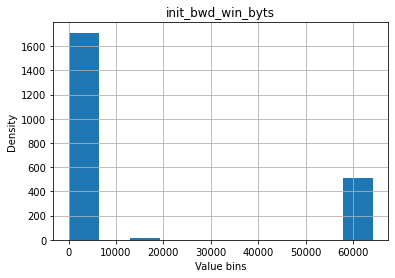

In [25]:
if 'init_bwd_win_byts' in df.columns:
    df['init_bwd_win_byts'].hist(figsize=(6,4), bins=10);
    plt.title("init_bwd_win_byts")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('init_bwd_win_byts.png', dpi=300)

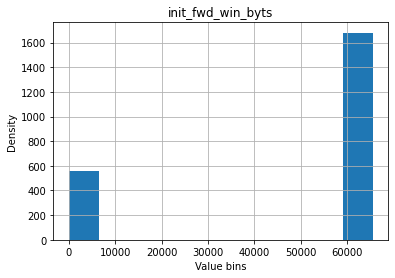

In [27]:
if 'init_fwd_win_byts' in df.columns:
    df['init_fwd_win_byts'].hist(figsize=(6,4), bins=10);
    plt.title("init_fwd_win_byts")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('init_fwd_win_byts.png', dpi=300)

Удаляем два этих признака, так как они криво собраны в датасете. На реальном трафике можно не удалять

In [ ]:
excluded2 = ['init_bwd_win_byts', 'init_fwd_win_byts']
df = df.drop(columns=excluded2, errors='ignore')

In [29]:
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(2239, 71) (2239,)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 730, 1: 707, 2: 130}

In [31]:
X_train.shape

(1567, 71)

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.91082803, 0.96815287, 0.96178344, 0.94904459, 0.94904459,
       0.96178344, 0.96815287, 0.96153846, 0.93589744, 0.96794872])

In [33]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- bwd_pkts_s <= 803.21
|   |--- fwd_pkts_b_avg <= 303.25
|   |   |--- pkt_len_max <= 234.50
|   |   |   |--- class: 0
|   |   |--- pkt_len_max >  234.50
|   |   |   |--- class: 0
|   |--- fwd_pkts_b_avg >  303.25
|   |   |--- class: 2
|--- bwd_pkts_s >  803.21
|   |--- bwd_iat_min <= 0.50
|   |   |--- class: 0
|   |--- bwd_iat_min >  0.50
|   |   |--- class: 1



In [34]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 328, 1: 294, 2: 50}

Обучаем одно деврево решений, чтобы понять какие признаки выбрать

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 1.00 
R^2 Validation Score: 1.00 
Out-of-bag Score: 1.00


In [36]:
X.columns

Index(['protocol', 'flow_duration', 'fwd_pkts_s', 'bwd_pkts_s', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'pkt_len_max', 'pkt_len_min', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fwd_header_len', 'bwd_header_len',
       'fwd_seg_size_min', 'fwd_act_data_pkts', 'flow_iat_mean',
       'flow_iat_max', 'flow_iat_min', 'flow_iat_std', 'fwd_iat_tot',
       'fwd_iat_max', 'fwd_iat_min', 'fwd_iat_mean', 'fwd_iat_std',
       'bwd_iat_tot', 'bwd_iat_max', 'bwd_iat_min', 'bwd_iat_mean',
       'bwd_iat_std', 'fin_flag_cnt', 'syn_flag_cnt', 'rst_flag_cnt',
       'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt', 'ece_flag_cnt',
       'down_up_ratio', 'pkt_size_avg', 'init_fwd_win_byts',
       'init_bwd_win_byts', 'active_max', 'active_min', 'active_mean',
       'active_std', 

In [37]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webattack_features = []

for index, i in enumerate(indices[:40]):
    webattack_features.append(features[i])
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#3	0.071	bwd_pkts_s
2.	#2	0.069	fwd_pkts_s
3.	#18	0.066	pkt_len_mean
4.	#47	0.062	pkt_size_avg
5.	#20	0.062	pkt_len_var
6.	#19	0.058	pkt_len_std
7.	#9	0.038	fwd_pkt_len_min
8.	#16	0.034	pkt_len_max
9.	#11	0.031	fwd_pkt_len_std
10.	#25	0.031	flow_iat_mean
11.	#10	0.027	fwd_pkt_len_mean
12.	#13	0.026	bwd_pkt_len_min
13.	#8	0.026	fwd_pkt_len_max
14.	#26	0.023	flow_iat_max
15.	#58	0.021	fwd_byts_b_avg
16.	#59	0.020	fwd_pkts_b_avg
17.	#17	0.019	pkt_len_min
18.	#64	0.019	fwd_seg_size_avg
19.	#69	0.018	subflow_fwd_byts
20.	#1	0.017	flow_duration
21.	#36	0.017	bwd_iat_min
22.	#68	0.017	subflow_bwd_pkts
23.	#24	0.014	fwd_act_data_pkts
24.	#6	0.013	totlen_fwd_pkts
25.	#28	0.013	flow_iat_std
26.	#49	0.012	init_bwd_win_byts
27.	#22	0.011	bwd_header_len
28.	#5	0.011	tot_bwd_pkts
29.	#65	0.010	bwd_seg_size_avg
30.	#67	0.010	subflow_fwd_pkts
31.	#48	0.009	init_fwd_win_byts
32.	#35	0.009	bwd_iat_max
33.	#55	0.009	idle_min
34.	#14	0.008	bwd_pkt_len_mean
35.	#21	0.008	fwd_header_len
36.	#4	0.008	tot_

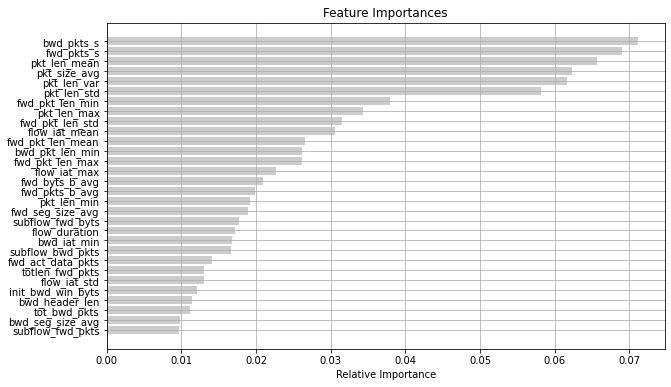

In [38]:
indices = np.argsort(importances)[-30:]
plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

NameError: name 'confusion_matrix' is not defined

In [40]:
max_features = 40
webattack_features = webattack_features[:max_features]
webattack_features

['bwd_pkts_s',
 'fwd_pkts_s',
 'pkt_len_mean',
 'pkt_size_avg',
 'pkt_len_var',
 'pkt_len_std',
 'fwd_pkt_len_min',
 'pkt_len_max',
 'fwd_pkt_len_std',
 'flow_iat_mean',
 'fwd_pkt_len_mean',
 'bwd_pkt_len_min',
 'fwd_pkt_len_max',
 'flow_iat_max',
 'fwd_byts_b_avg',
 'fwd_pkts_b_avg',
 'pkt_len_min',
 'fwd_seg_size_avg',
 'subflow_fwd_byts',
 'flow_duration',
 'bwd_iat_min',
 'subflow_bwd_pkts',
 'fwd_act_data_pkts',
 'totlen_fwd_pkts',
 'flow_iat_std',
 'init_bwd_win_byts',
 'bwd_header_len',
 'tot_bwd_pkts',
 'bwd_seg_size_avg',
 'subflow_fwd_pkts',
 'init_fwd_win_byts',
 'bwd_iat_max',
 'idle_min',
 'bwd_pkt_len_mean',
 'fwd_header_len',
 'tot_fwd_pkts',
 'idle_mean',
 'subflow_bwd_byts',
 'bwd_iat_std',
 'bwd_iat_tot']

Строи карту кореляции между парами признаков

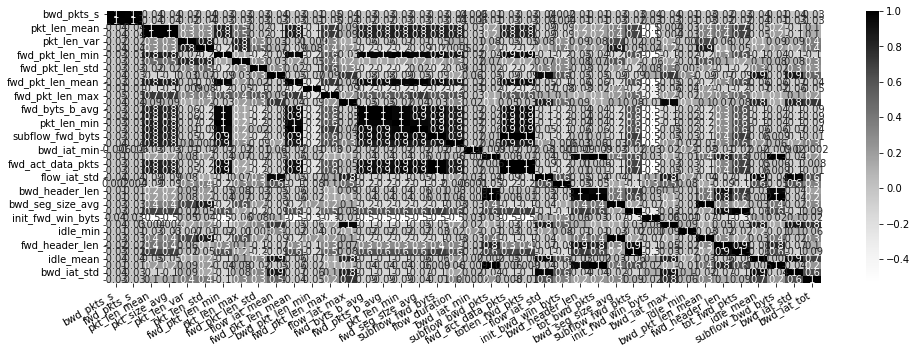

In [42]:
import seaborn as sns
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (16, 5)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

Удаляем признаки, кориляция которых больше 0.95. Делаем так из-за того, что в данных могут быть выбросы и тогда данная матрица может повышать значения у признаков без зависимости, а так отбросим только те, что явно корилируют

In [43]:
cor = df[webattack_features].corr()

In [44]:
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))

In [45]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [46]:
to_drop

['fwd_pkts_s',
 'pkt_size_avg',
 'fwd_pkt_len_mean',
 'fwd_byts_b_avg',
 'fwd_pkts_b_avg',
 'pkt_len_min',
 'fwd_seg_size_avg',
 'fwd_act_data_pkts',
 'totlen_fwd_pkts',
 'flow_iat_std',
 'bwd_header_len',
 'tot_bwd_pkts',
 'bwd_iat_max',
 'bwd_pkt_len_mean',
 'tot_fwd_pkts',
 'subflow_bwd_byts',
 'bwd_iat_std']

In [47]:
to_be_removed = to_drop
webattack_features = [item for item in webattack_features if item not in to_be_removed]
webattack_features = webattack_features[:15]
webattack_features

['bwd_pkts_s',
 'pkt_len_mean',
 'pkt_len_var',
 'pkt_len_std',
 'fwd_pkt_len_min',
 'pkt_len_max',
 'fwd_pkt_len_std',
 'flow_iat_mean',
 'bwd_pkt_len_min',
 'fwd_pkt_len_max',
 'flow_iat_max',
 'subflow_fwd_byts',
 'flow_duration',
 'bwd_iat_min',
 'subflow_bwd_pkts']

Итоговые признаки и их матрица кор

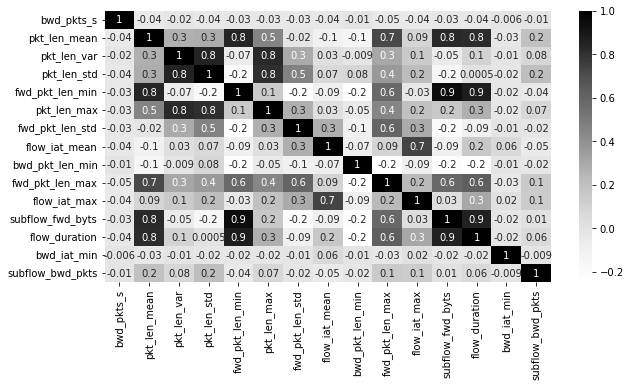

In [48]:
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (10, 5)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys');


Дальше обучаем ансамбль из уже имеющейся тетрадки

Гиперпараметра для деревьев выбираем из этих

In [49]:
parameters = {'n_estimators': [30, 50, 70, 100], 
              'min_samples_leaf': [3, 5, 7, 10],
              'max_features': [3, 5, 7, 10, 12], 
              'max_depth': [5, 10, 17, 23]}

In [50]:
X = df[webattack_features]
print(X.shape, y.shape)

(2239, 15) (2239,)


In [51]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [52]:
from sklearn.model_selection import GridSearchCV

In [53]:
parameters = {'n_estimators': [10],
              'min_samples_leaf': [3],
              'max_features': [3], 
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 20, 30, 50]}
scoring = {'f1', 'accuracy'}
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')
results = gcv.cv_results_

/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_classificatio

CPU times: user 2.63 s, sys: 28.2 ms, total: 2.66 s
Wall time: 2.65 s


/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_classificatio

In [54]:
cv_results = pd.DataFrame(gcv.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.012007      0.001057         0.001964        0.000405   
1       0.012279      0.000612         0.001952        0.000380   
2       0.012064      0.000352         0.001723        0.000217   
3       0.011941      0.000398         0.001746        0.000188   
4       0.012457      0.000643         0.001961        0.000307   

  param_max_depth param_max_features param_min_samples_leaf  \
0               3                  3                      3   
1               4                  3                      3   
2               5                  3                      3   
3               6                  3                      3   
4               7                  3                      3   

  param_n_estimators                                             params  \
0                 10  {'max_depth': 3, 'max_features': 3, 'min_sampl...   
1                 10  {'max_depth': 4, 'max_features': 3, 'min_sampl...   
2                 10  {'max_depth': 5, 'max_features': 3, 'min_sampl...   
3                 10  {'max_depth': 6, 'max_features': 3, 'min_sampl...   
4                 10  {'max_depth': 7, 'max_features': 3, 'min_sampl...   

   split0_test_f1  ...  split2_train_accuracy  split3_train_accuracy  \
0             NaN  ...                    NaN                    NaN   
1             NaN  ...                    NaN                    NaN   
2             NaN  ...                    NaN                    NaN   
3             NaN  ...                    NaN                    NaN   
4             NaN  ...                    NaN                    NaN   

   split4_train_accuracy  split5_train_accuracy  split6_train_accuracy  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   split7_train_accuracy  split8_train_accuracy  split9_train_accuracy  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   mean_train_accuracy  std_train_accuracy  
0                  NaN                 NaN  
1                  NaN                 NaN  
2                  NaN                 NaN  
3                  NaN                 NaN  
4                  NaN                 NaN  

[5 rows x 59 columns]

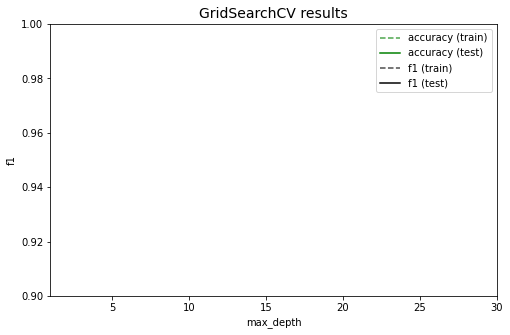

In [55]:
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_multi_metric_evaluation.html
plt.figure(figsize=(8, 5))
plt.title("GridSearchCV results", fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("f1")

ax = plt.gca()
ax.set_xlim(1, 30)
ax.set_ylim(0.9, 1)

X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index] + 0.3, best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('GridSearchCV_results.png', dpi=300)
plt.show()

In [56]:
from sklearn.decomposition import PCA

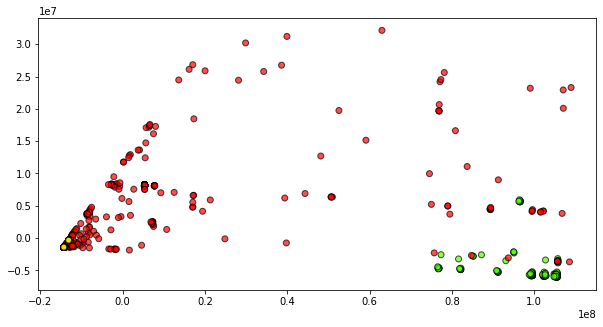

In [57]:
pca = PCA(n_components=2)
pca.fit(X.to_numpy())
X_pca = pca.transform(X.to_numpy())
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)

In [58]:
parameters = {'n_estimators': [30, 50, 70, 100], 
              'min_samples_leaf': [3, 5, 7, 10],
              'max_features': [3, 5, 7, 10, 12], 
              'max_depth': [5, 10, 17, 23]}

In [59]:
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=3, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')

/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/dmitrii/.local/lib/python3.10/site-packages/sklearn/metrics/_classificatio

CPU times: user 1min 31s, sys: 554 ms, total: 1min 32s
Wall time: 1min 31s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [5, 10, 17, 23],
                         'max_features': [3, 5, 7, 10, 12],
                         'min_samples_leaf': [3, 5, 7, 10],
                         'n_estimators': [30, 50, 70, 100]},
             refit='f1', return_train_score=True, scoring={'f1', 'accuracy'})

In [60]:
gcv.best_estimator_ 

RandomForestClassifier(max_depth=5, max_features=3, min_samples_leaf=3,
                       n_estimators=30, random_state=1)

In [61]:
gcv.best_params_

{'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 3, 'n_estimators': 30}

In [62]:
gcv.best_score_

nan

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1567, 15) (1567,)
(672, 15) (672,)


In [64]:
rfc = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
# rfc = RandomForestClassifier(n_estimators=250, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [65]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
    
for index, i in enumerate(indices[:10]):
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#0	0.421	bwd_pkts_s
2.	#1	0.149	pkt_len_mean
3.	#4	0.134	fwd_pkt_len_min
4.	#6	0.077	fwd_pkt_len_std
5.	#3	0.046	pkt_len_std
6.	#11	0.043	subflow_fwd_byts
7.	#2	0.033	pkt_len_var
8.	#5	0.032	pkt_len_max
9.	#13	0.026	bwd_iat_min
10.	#9	0.024	fwd_pkt_len_max
